# Visual Memory Debug Notebook

Step-by-step training with synthetic frames to inspect:
- **Fast learner** loss per wake step
- **Slow learner** distillation + raw losses
- **Curiosity reward** (prediction error)
- **Policy** loss & clipping penalty
- **Sleep cycle** SWS / REM / Tether losses
- Loss curves over time

In [ ]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))

import numpy as np
import random
import torch
import matplotlib.pyplot as plt
from collections import defaultdict

from project_curiosity.visual_memory.trainer import VisualTrainer
from project_curiosity.visual_memory import config as C

%matplotlib inline
plt.rcParams['figure.figsize'] = (14, 4)
plt.rcParams['figure.dpi'] = 100

## 1. Synthetic Environment

A simple simulated environment that generates random RGB frames and applies
actions with joint-limit clipping, so we can run the full training loop
without real robot hardware.

In [ ]:
class SyntheticEnv:
    """Minimal simulated environment for debugging.
    
    Generates 224x224 RGB frames with a colored square whose position
    is controlled by the cumulative servo angles. This gives the world
    model a learnable signal (action -> visual change).
    """
    def __init__(self, size=224):
        self.size = size
        self.angles = [0.0, 0.0]  # current joint positions
        self.s1_range = C.SERVO_LIMITS[0]
        self.s2_range = C.SERVO_LIMITS[1]

    def _render(self):
        """Render a frame based on current joint angles."""
        frame = np.zeros((self.size, self.size, 3), dtype=np.uint8)
        # Map angles to pixel position
        cx = int(np.interp(self.angles[0], self.s1_range, [20, self.size - 20]))
        cy = int(np.interp(self.angles[1], self.s2_range, [20, self.size - 20]))
        # Draw a colored square
        half = 15
        x0, x1 = max(0, cx - half), min(self.size, cx + half)
        y0, y1 = max(0, cy - half), min(self.size, cy + half)
        frame[y0:y1, x0:x1] = [200, 80, 80]
        # Add some noise so frames aren't identical
        noise = np.random.randint(0, 15, frame.shape, dtype=np.uint8)
        frame = np.clip(frame.astype(np.int16) + noise, 0, 255).astype(np.uint8)
        return frame

    def get_frame(self):
        return self._render()

    @property
    def current_angles(self):
        return list(self.angles)

    def step(self, action):
        """Apply action, clip to limits, return (next_frame, actual_action)."""
        d1 = max(-C.ACTION_SCALE, min(C.ACTION_SCALE, action[0]))
        d2 = max(-C.ACTION_SCALE, min(C.ACTION_SCALE, action[1]))
        new_s1 = max(self.s1_range[0], min(self.s1_range[1], self.angles[0] + d1))
        new_s2 = max(self.s2_range[0], min(self.s2_range[1], self.angles[1] + d2))
        actual = [new_s1 - self.angles[0], new_s2 - self.angles[1]]
        self.angles = [new_s1, new_s2]
        return self._render(), actual

env = SyntheticEnv()
print(f'Synthetic env ready  |  servo limits: S1={C.SERVO_LIMITS[0]}, S2={C.SERVO_LIMITS[1]}')

## 2. Create Trainer (fresh model)

In [ ]:
import shutil, tempfile

# Use a temp directory so we don't pollute the real models/ folder
_tmp_models = tempfile.mkdtemp(prefix='vm_debug_')
C.MODELS_DIR = _tmp_models

# Reduce warmup & cycle length for faster iteration in the notebook
C.CURIOSITY_WARMUP_STEPS = 10
C.WAKE_STEPS_PER_CYCLE = 60
C.SWS_STEPS = 30
C.REM_STEPS = 30
C.TETHER_STEPS = 5
C.POLICY_TRAIN_INTERVAL = 2

trainer = VisualTrainer(model_name='debug')
print(f'\nDevice: {C.DEVICE}')
print(f'Model dir: {trainer.model_dir}')
print(f'Fast params: {sum(p.numel() for p in trainer.model.fast_learner.parameters()):,}')
print(f'Slow params: {sum(p.numel() for p in trainer.model.slow_learner.parameters()):,}')
print(f'Policy params: {sum(p.numel() for p in trainer.model.policy.parameters()):,}')

## 3. Run Wake Steps & Collect Metrics

In [ ]:
NUM_WAKE_STEPS = 80  # enough to trigger one sleep cycle (60) + extra

history = defaultdict(list)
current_frame = env.get_frame()

for i in range(NUM_WAKE_STEPS):
    # Generate action (curiosity after warmup, random before)
    joint_pos = env.current_angles
    commanded = trainer.get_curiosity_action(current_frame, joint_pos, explore=True)

    next_frame, actual_action = env.step(commanded)

    stats = trainer.train_step(
        current_frame, actual_action, next_frame,
        joint_positions=joint_pos, commanded_action=commanded,
    )

    # Record
    history['step'].append(stats['step'])
    history['fast_loss'].append(stats['fast_loss'])
    history['curiosity_reward'].append(stats['curiosity_reward'])

    if stats['slow_wake_loss'] is not None:
        history['slow_distill'].append(stats['slow_wake_loss']['distill'])
        history['slow_raw'].append(stats['slow_wake_loss']['raw'])
        history['slow_step'].append(stats['step'])

    if stats['policy_stats'] is not None:
        history['policy_loss'].append(stats['policy_stats']['policy_loss'])
        history['policy_curiosity'].append(stats['policy_stats']['curiosity_reward'])
        history['policy_clip'].append(stats['policy_stats']['clipping_penalty'])
        history['policy_step'].append(stats['step'])

    # If sleep triggered, run it and record
    if stats['should_sleep']:
        print(f'\n--- Sleep triggered at step {stats["step"]} ---')
        sleep_stats = trainer.sleep_cycle()
        history['sleep_cycles'].append({
            'cycle': sleep_stats['cycle'],
            'sws': sleep_stats['sws'],
            'rem': sleep_stats['rem'],
            'tether': sleep_stats['tether'],
        })

    current_frame = next_frame

print(f'\nCompleted {NUM_WAKE_STEPS} steps  |  '
      f'trainer.step_count={trainer.step_count}  |  '
      f'cycles={trainer.cycle_count}  |  '
      f'replay={len(trainer.replay_buffer)}')

## 4. Plot Wake Losses

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# Fast learner loss
ax = axes[0]
ax.plot(history['step'], history['fast_loss'], linewidth=0.8)
ax.set_title('Fast Learner Loss (per step)')
ax.set_xlabel('Step')
ax.set_ylabel('MSE')
ax.grid(True, alpha=0.3)

# Slow learner wake losses
ax = axes[1]
if history['slow_step']:
    ax.plot(history['slow_step'], history['slow_distill'], label='Distill', linewidth=0.8)
    ax.plot(history['slow_step'], history['slow_raw'], label='Raw', linewidth=0.8)
    ax.legend(fontsize=8)
ax.set_title('Slow Learner Wake Losses')
ax.set_xlabel('Step')
ax.set_ylabel('MSE')
ax.grid(True, alpha=0.3)

# Curiosity reward
ax = axes[2]
ax.plot(history['step'], history['curiosity_reward'], linewidth=0.8, color='tab:orange')
ax.set_title('Curiosity Reward (prediction error)')
ax.set_xlabel('Step')
ax.set_ylabel('MSE')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Plot Policy Training

In [ ]:
if history['policy_step']:
    fig, axes = plt.subplots(1, 3, figsize=(16, 4))

    ax = axes[0]
    ax.plot(history['policy_step'], history['policy_loss'], linewidth=0.8, color='tab:red')
    ax.set_title('Policy Loss (= -curiosity + clip_penalty)')
    ax.set_xlabel('Step')
    ax.grid(True, alpha=0.3)

    ax = axes[1]
    ax.plot(history['policy_step'], history['policy_curiosity'], linewidth=0.8, color='tab:green')
    ax.set_title('Policy Curiosity Reward')
    ax.set_xlabel('Step')
    ax.grid(True, alpha=0.3)

    ax = axes[2]
    ax.plot(history['policy_step'], history['policy_clip'], linewidth=0.8, color='tab:purple')
    ax.set_title('Clipping Penalty')
    ax.set_xlabel('Step')
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
else:
    print('No policy training steps recorded (warmup not reached?).')

## 6. Inspect Sleep Cycle Losses

In [ ]:
for sc in history.get('sleep_cycles', []):
    print(f"=== Sleep Cycle {sc['cycle']} ===")
    sws = sc['sws']
    rem = sc['rem']
    tether = sc['tether']

    fig, axes = plt.subplots(1, 3, figsize=(16, 4))

    # SWS
    ax = axes[0]
    if sws.get('log') and sws['log'].get('L_sws'):
        ax.plot(sws['log']['L_sws'], linewidth=0.8)
        ax.set_title(f"SWS  (avg L_dyn={sws.get('avg_L_dyn', 0):.6f})")
    else:
        ax.set_title(f"SWS  ({sws.get('status', 'n/a')})")
    ax.set_xlabel('SWS step')
    ax.set_ylabel('Loss')
    ax.grid(True, alpha=0.3)

    # REM
    ax = axes[1]
    if rem.get('log') and rem['log'].get('L_rem'):
        ax.plot(rem['log']['L_rem'], linewidth=0.8, color='tab:orange')
        ax.set_title(f"REM  (avg L_ms={rem.get('avg_L_ms', 0):.6f})")
    else:
        ax.set_title(f"REM  ({rem.get('status', 'n/a')})")
    ax.set_xlabel('REM step')
    ax.set_ylabel('Loss')
    ax.grid(True, alpha=0.3)

    # Tether
    ax = axes[2]
    ax.bar(['Tether Loss'], [tether.get('avg_tether_loss', 0)], color='tab:green')
    ax.set_title(f"Tether  ({tether.get('tether_steps', 0)} steps)")
    ax.set_ylabel('Avg Loss')
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

if not history.get('sleep_cycles'):
    print('No sleep cycles triggered yet. Increase NUM_WAKE_STEPS.')

## 7. Inspect Model Predictions

Compare Fast vs Slow predictions on a sample from the replay buffer.

In [ ]:
if len(trainer.replay_buffer) > 0:
    sample = random.choice(list(trainer.replay_buffer))
    state = sample['state_emb']
    action = sample['action']
    target = sample['next_state_emb']

    inp = torch.cat([state.unsqueeze(0), action.unsqueeze(0)], dim=-1)

    with torch.no_grad():
        pred_fast = trainer.model.fast_learner(inp).squeeze(0)
        pred_slow = trainer.model.slow_learner(inp).squeeze(0)

    err_fast = torch.nn.functional.mse_loss(pred_fast, target).item()
    err_slow = torch.nn.functional.mse_loss(pred_slow, target).item()
    fast_slow_diff = torch.nn.functional.mse_loss(pred_fast, pred_slow).item()

    print(f'Fast  -> target MSE : {err_fast:.6f}')
    print(f'Slow  -> target MSE : {err_slow:.6f}')
    print(f'Fast <-> Slow  MSE  : {fast_slow_diff:.6f}')

    # Visualise first 50 dims of the embeddings
    dims = min(50, C.ENCODED_DIM)
    fig, ax = plt.subplots(figsize=(14, 3))
    x = np.arange(dims)
    ax.plot(x, target[:dims].cpu().numpy(), label='Target', alpha=0.7)
    ax.plot(x, pred_fast[:dims].cpu().numpy(), label=f'Fast (err={err_fast:.4f})', alpha=0.7)
    ax.plot(x, pred_slow[:dims].cpu().numpy(), label=f'Slow (err={err_slow:.4f})', alpha=0.7)
    ax.set_title('Embedding comparison (first 50 dims)')
    ax.set_xlabel('Dimension')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print('Replay buffer is empty — run training steps first.')

## 8. Run More Steps / Additional Sleep Cycles

Re-run this cell to accumulate more data and re-plot above.

In [ ]:
EXTRA_STEPS = 60

for i in range(EXTRA_STEPS):
    joint_pos = env.current_angles
    commanded = trainer.get_curiosity_action(current_frame, joint_pos, explore=True)
    next_frame, actual_action = env.step(commanded)

    stats = trainer.train_step(
        current_frame, actual_action, next_frame,
        joint_positions=joint_pos, commanded_action=commanded,
    )

    history['step'].append(stats['step'])
    history['fast_loss'].append(stats['fast_loss'])
    history['curiosity_reward'].append(stats['curiosity_reward'])

    if stats['slow_wake_loss'] is not None:
        history['slow_distill'].append(stats['slow_wake_loss']['distill'])
        history['slow_raw'].append(stats['slow_wake_loss']['raw'])
        history['slow_step'].append(stats['step'])

    if stats['policy_stats'] is not None:
        history['policy_loss'].append(stats['policy_stats']['policy_loss'])
        history['policy_curiosity'].append(stats['policy_stats']['curiosity_reward'])
        history['policy_clip'].append(stats['policy_stats']['clipping_penalty'])
        history['policy_step'].append(stats['step'])

    if stats['should_sleep']:
        print(f'--- Sleep triggered at step {stats["step"]} ---')
        sleep_stats = trainer.sleep_cycle()
        history['sleep_cycles'].append({
            'cycle': sleep_stats['cycle'],
            'sws': sleep_stats['sws'],
            'rem': sleep_stats['rem'],
            'tether': sleep_stats['tether'],
        })

    current_frame = next_frame

print(f'Total steps: {trainer.step_count}  |  cycles: {trainer.cycle_count}  |  replay: {len(trainer.replay_buffer)}')

## 9. Joint-Limit Stuck Test

Force the servos to a corner (both at max limits) so every action into the
limit gets clipped to zero.  Then run training steps and observe whether:

1. **Clipping penalty** rises (the policy is penalised for commanding into limits)
2. **Commanded actions** shift away from the limit direction over time
3. **Curiosity reward** stays healthy (the model still finds "interesting" moves)

If the policy is working correctly, it should learn to stop pushing into the
wall and instead command actions that move *away* from the limit.

In [11]:
# --- Force env to the max joint-limit corner ---
env.angles = [C.SERVO_LIMITS[0][1], C.SERVO_LIMITS[1][1]]  # (90.0, 40.0)
print(f'Forced env to joint limits: {env.current_angles}')
print(f'S1 max={C.SERVO_LIMITS[0][1]}, S2 max={C.SERVO_LIMITS[1][1]}')
print(f'Any positive action will be clipped to 0.\n')

STUCK_STEPS = 120  # run enough steps to see adaptation

stuck_history = defaultdict(list)
current_frame = env.get_frame()

for i in range(STUCK_STEPS):
    joint_pos = env.current_angles
    commanded = trainer.get_curiosity_action(current_frame, joint_pos, explore=True)
    next_frame, actual_action = env.step(commanded)

    stats = trainer.train_step(
        current_frame, actual_action, next_frame,
        joint_positions=joint_pos, commanded_action=commanded,
    )

    # Track commanded vs actual (to see clipping)
    stuck_history['step'].append(stats['step'])
    stuck_history['cmd_s1'].append(commanded[0])
    stuck_history['cmd_s2'].append(commanded[1])
    stuck_history['act_s1'].append(actual_action[0])
    stuck_history['act_s2'].append(actual_action[1])
    stuck_history['fast_loss'].append(stats['fast_loss'])
    stuck_history['curiosity_reward'].append(stats['curiosity_reward'])
    stuck_history['joint_s1'].append(env.angles[0])
    stuck_history['joint_s2'].append(env.angles[1])

    # Clipping amount: how much was lost
    stuck_history['clip_s1'].append(abs(commanded[0] - actual_action[0]))
    stuck_history['clip_s2'].append(abs(commanded[1] - actual_action[1]))

    if stats['policy_stats'] is not None:
        stuck_history['policy_loss'].append(stats['policy_stats']['policy_loss'])
        stuck_history['policy_curiosity'].append(stats['policy_stats']['curiosity_reward'])
        stuck_history['policy_clip'].append(stats['policy_stats']['clipping_penalty'])
        stuck_history['policy_step'].append(stats['step'])

    # Run sleep if triggered
    if stats['should_sleep']:
        print(f'  Sleep triggered at step {stats["step"]}')
        sleep_stats = trainer.sleep_cycle()

    current_frame = next_frame

print(f'\nDone. Steps: {STUCK_STEPS}  |  Final angles: {env.current_angles}')
print(f'Moved away from limit? S1: {env.angles[0] < C.SERVO_LIMITS[0][1]}, '
      f'S2: {env.angles[1] < C.SERVO_LIMITS[1][1]}')

Forced env to joint limits: [90.0, 40.0]
S1 max=90.0, S2 max=40.0
Any positive action will be clipped to 0.

  Sleep triggered at step 120

=== Sleep Cycle 2 ===
  SWS: 30 steps...
    avg L_dyn=0.000407
  REM: 30 steps, K=3...
    avg L_ms=0.002778
  Tether: 5 steps, avg_loss=0.001765
Model 'debug' saved (step=120, cycle=2, replay=120)
  Sleep triggered at step 180

=== Sleep Cycle 3 ===
  SWS: 30 steps...
    avg L_dyn=0.000248
  REM: 30 steps, K=3...
    avg L_ms=0.002639
  Tether: 5 steps, avg_loss=0.001409
Model 'debug' saved (step=180, cycle=3, replay=180)

Done. Steps: 120  |  Final angles: [63.65593525022268, -17.91325980424881]
Moved away from limit? S1: True, S2: True


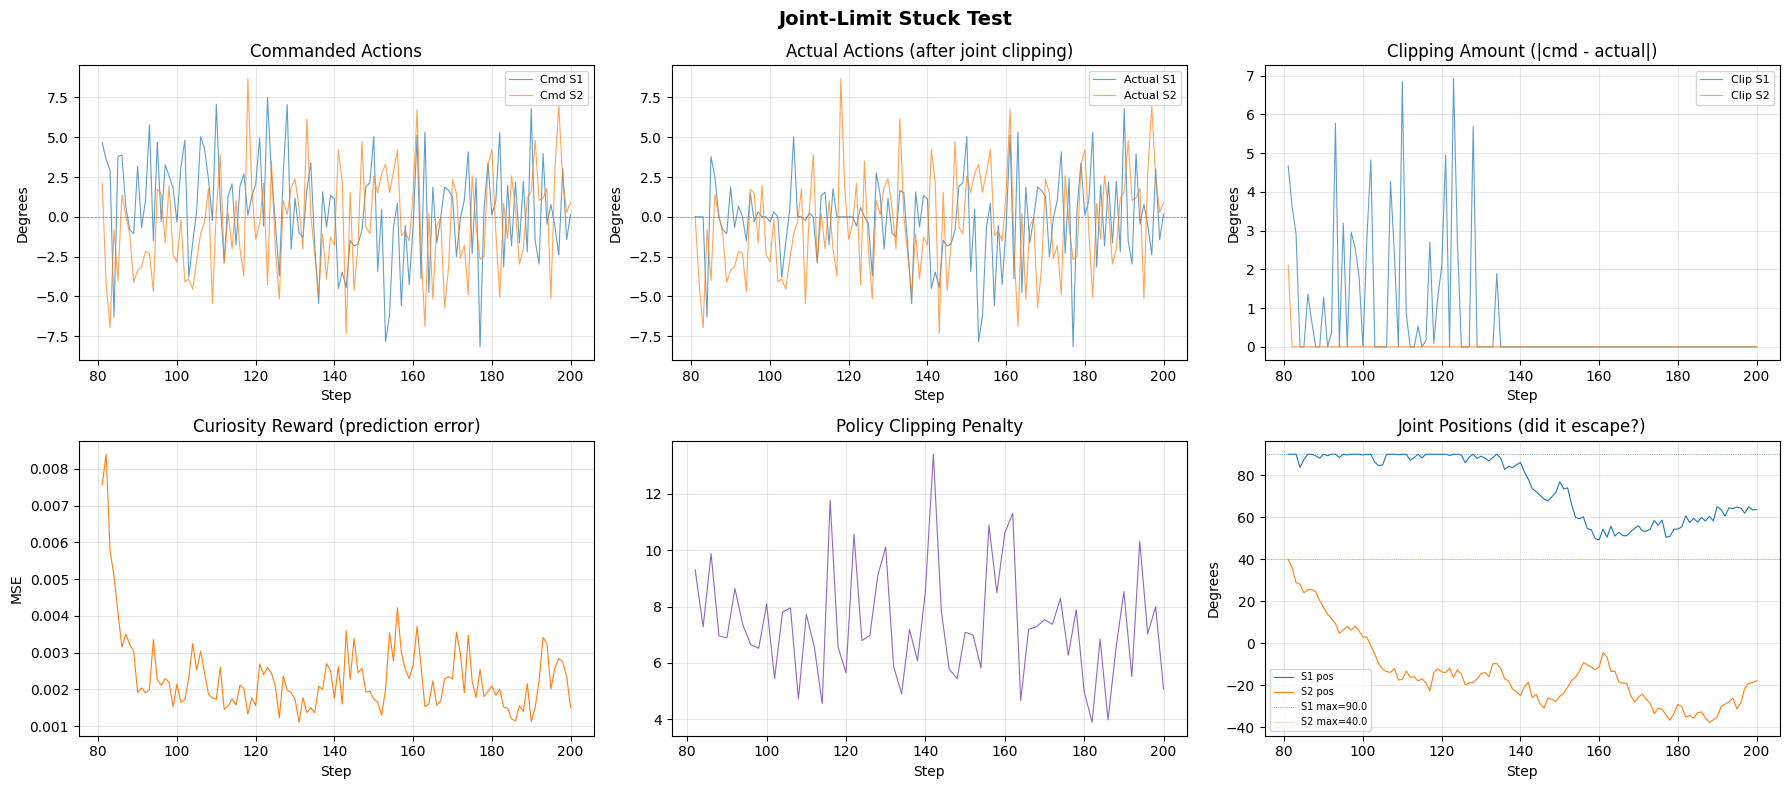


--- Summary ---
First half avg cmd S1: +1.30  |  Second half: -0.37
First half avg cmd S2: -1.05  |  Second half: +0.12
First half avg clip:   1.403  |  Second half: 0.000
Final joint pos: S1=63.7, S2=-17.9
Escaped S1 limit: True  |  Escaped S2 limit: True


In [12]:
fig, axes = plt.subplots(2, 3, figsize=(18, 8))

steps = stuck_history['step']

# --- Row 1: Actions & Clipping ---

# Commanded actions
ax = axes[0, 0]
ax.plot(steps, stuck_history['cmd_s1'], label='Cmd S1', alpha=0.7, linewidth=0.8)
ax.plot(steps, stuck_history['cmd_s2'], label='Cmd S2', alpha=0.7, linewidth=0.8)
ax.axhline(0, color='gray', linestyle='--', linewidth=0.5)
ax.set_title('Commanded Actions')
ax.set_xlabel('Step')
ax.set_ylabel('Degrees')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# Actual actions (after clipping)
ax = axes[0, 1]
ax.plot(steps, stuck_history['act_s1'], label='Actual S1', alpha=0.7, linewidth=0.8)
ax.plot(steps, stuck_history['act_s2'], label='Actual S2', alpha=0.7, linewidth=0.8)
ax.axhline(0, color='gray', linestyle='--', linewidth=0.5)
ax.set_title('Actual Actions (after joint clipping)')
ax.set_xlabel('Step')
ax.set_ylabel('Degrees')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# Clipping amount
ax = axes[0, 2]
ax.plot(steps, stuck_history['clip_s1'], label='Clip S1', alpha=0.7, linewidth=0.8)
ax.plot(steps, stuck_history['clip_s2'], label='Clip S2', alpha=0.7, linewidth=0.8)
ax.set_title('Clipping Amount (|cmd - actual|)')
ax.set_xlabel('Step')
ax.set_ylabel('Degrees')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# --- Row 2: Rewards, Policy, Joint Positions ---

# Curiosity reward
ax = axes[1, 0]
ax.plot(steps, stuck_history['curiosity_reward'], linewidth=0.8, color='tab:orange')
ax.set_title('Curiosity Reward (prediction error)')
ax.set_xlabel('Step')
ax.set_ylabel('MSE')
ax.grid(True, alpha=0.3)

# Policy clipping penalty
ax = axes[1, 1]
if stuck_history['policy_step']:
    ax.plot(stuck_history['policy_step'], stuck_history['policy_clip'],
            linewidth=0.8, color='tab:purple')
    ax.set_title('Policy Clipping Penalty')
else:
    ax.set_title('Policy Clipping Penalty (no data)')
ax.set_xlabel('Step')
ax.grid(True, alpha=0.3)

# Joint positions over time
ax = axes[1, 2]
ax.plot(steps, stuck_history['joint_s1'], label='S1 pos', linewidth=0.8)
ax.plot(steps, stuck_history['joint_s2'], label='S2 pos', linewidth=0.8)
ax.axhline(C.SERVO_LIMITS[0][1], color='tab:blue', linestyle=':', linewidth=0.5, label=f'S1 max={C.SERVO_LIMITS[0][1]}')
ax.axhline(C.SERVO_LIMITS[1][1], color='tab:orange', linestyle=':', linewidth=0.5, label=f'S2 max={C.SERVO_LIMITS[1][1]}')
ax.set_title('Joint Positions (did it escape?)')
ax.set_xlabel('Step')
ax.set_ylabel('Degrees')
ax.legend(fontsize=7)
ax.grid(True, alpha=0.3)

plt.suptitle('Joint-Limit Stuck Test', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Summary stats
n = len(steps)
half = n // 2
print(f'\n--- Summary ---')
print(f'First half avg cmd S1: {np.mean(stuck_history["cmd_s1"][:half]):+.2f}  |  '
      f'Second half: {np.mean(stuck_history["cmd_s1"][half:]):+.2f}')
print(f'First half avg cmd S2: {np.mean(stuck_history["cmd_s2"][:half]):+.2f}  |  '
      f'Second half: {np.mean(stuck_history["cmd_s2"][half:]):+.2f}')
print(f'First half avg clip:   {np.mean(stuck_history["clip_s1"][:half]) + np.mean(stuck_history["clip_s2"][:half]):.3f}  |  '
      f'Second half: {np.mean(stuck_history["clip_s1"][half:]) + np.mean(stuck_history["clip_s2"][half:]):.3f}')
print(f'Final joint pos: S1={env.angles[0]:.1f}, S2={env.angles[1]:.1f}')
escaped_s1 = env.angles[0] < C.SERVO_LIMITS[0][1]
escaped_s2 = env.angles[1] < C.SERVO_LIMITS[1][1]
print(f'Escaped S1 limit: {escaped_s1}  |  Escaped S2 limit: {escaped_s2}')

## 10. Cleanup

Remove the temporary model directory when done.

In [ ]:
# Uncomment to clean up temp files:
# shutil.rmtree(_tmp_models, ignore_errors=True)
# print(f'Removed {_tmp_models}')